# Data Preprocessing

In [1]:
import numpy as np
import os
import pandas as pd
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [2]:
# Import data

def import_train_data(dir):
    df = None
    min_cols,max_cols = (None,None)
    for file in os.listdir(dir):
        print(f"train: {file}")
        _df = pd.read_csv(f"{os.path.join(dir,file)}", sep="\t", header=None)
        _df = _df.drop(columns=[0])
        if df is None:
            df = _df
        else:
            df = pd.concat([df,_df])

    min_cols = df.min()
    max_cols = df.max()
    df = (df-df.min())/(df.max()-df.min())
        
    return df, min_cols, max_cols

def import_test_data(dir, min_cols, max_cols):
    dfs = []

    for file in os.listdir(dir):
        print(f"test: {file}")
        _df = pd.read_csv(f"{os.path.join(dir,file)}", sep="\t", header=None)
        _df = _df.drop(columns=[0])        
        _df = (_df-min_cols)/(max_cols-min_cols)
        dfs.append(_df)
        
    return dfs

train_dfs, train_min, train_max = import_train_data("/Users/faith/Desktop/Projects/tsad/data/train")
test_dfs = import_test_data("/Users/faith/Desktop/Projects/tsad/data/test", train_min, train_max)

train: 07112001.txt
train: 06112001.txt
train: 08112001.txt
train: 05112001.txt
test: 20112001.txt
test: 30102001.txt
test: 17112001.txt
test: 09112001.txt


In [3]:
# Convert to Tensors

downsample = 20
train = torch.FloatTensor(train_dfs[::downsample].values)
test = torch.FloatTensor(test_dfs[0][::downsample].values)

In [4]:
# Create Dataset Class

class TimewindowDataset(Dataset):
    def __init__(self, data, window_size):
        self.num_timesteps, self.num_sensors = data.shape
        self.data = data
        self.window_size = window_size
        
    def __len__(self):
        return self.num_timesteps-self.window_size-1
    
    def __getitem__(self,i):
        src = self.data[i:i+self.window_size]
        tgt = self.data[i+1:i+self.window_size+1]
        output = self.data[i+2:i+self.window_size+2]
        return (src, tgt, output)
    
window_size = 10
num_sensors = train.shape[1]

batch_size = 100
train_dataset = TimewindowDataset(train, window_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, drop_last=True, shuffle=False)

# Model

In [5]:
import torch
import torch.nn as nn 
from torch import nn, Tensor
import torch.nn.functional as F
import math
import pandas as pd
from pathlib import Path

In [6]:
class PositionalEncoder(nn.Module):
    def __init__(
        self, 
        dropout: float=0., 
        max_seq_len: int=1000, 
        d_model: int=512,
        batch_first: bool=False
        ):

        super().__init__()

        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)
        self.batch_first = batch_first
        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        if self.batch_first:
            pe = torch.zeros(1, max_seq_len, d_model)
            pe[0, :, 0::2] = torch.sin(position * div_term)
            pe[0, :, 1::2] = torch.cos(position * div_term)
        else:
            pe = torch.zeros(max_seq_len, 1, d_model)
            pe[:, 0, 0::2] = torch.sin(position * div_term)
            pe[:, 0, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        if self.batch_first:
            x = x + self.pe[:,:x.size(1)]
        else:
            x = x + self.pe[:x.size(0)]

        return self.dropout(x)

In [7]:
def generate_square_subsequent_mask(dim1: int, dim2: int) -> Tensor:
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)

In [8]:
class TimeSeriesTransformer(nn.Module):

    def __init__(self, 
        input_size: int, # number of input variables. 1 if univariate.
        window_size: int, # length of the input sequence fed to the decoder
        batch_first: bool,
        dim_val: int=512,  # d_model. All sub-layers in the model produce outputs of dimension dim_val
        n_encoder_layers: int=4, # number of stacked encoder layers in the encoder
        n_decoder_layers: int=4, # number of stacked encoder layers in the decoder
        n_heads: int=1, # number of attention heads (aka parallel attention layers)
        dropout_encoder: float=0., 
        dropout_decoder: float=0.,
        dropout_pos_enc: float=0.,
        dim_feedforward_encoder: int=300, # number of neurons in the encoder's linear layer
        dim_feedforward_decoder: int=300,# number of neurons in the decoder's linear layer
        num_predicted_features: int=1
        ): 

        super().__init__() 

        self.window_size = window_size

        # Creating the three linear layers needed for the model
        self.encoder_input_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )

        self.decoder_input_layer = nn.Linear(
            in_features=num_predicted_features,
            out_features=dim_val
            )  
        
        self.linear_mapping = nn.Linear(
            in_features=dim_val, 
            out_features=dim_val
            )

        self.linear_mapping2 = nn.Linear(
            in_features=dim_val, 
            out_features=dim_val
            )

        self.linear_mapping3 = nn.Linear(
            in_features=dim_val, 
            out_features=num_predicted_features
            )

        
        # Create positional encoder
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc
            )

        # The encoder layer used in the paper is identical to the one used by
        # Vaswani et al (2017) on which the PyTorch module is based.
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=batch_first
            )

        # Stack the encoder layers in nn.TransformerDecoder
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers, 
            norm=None
            )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=batch_first
            )

        # Stack the decoder layers in nn.TransformerDecoder
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
            )

    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None, 
                tgt_mask: Tensor=None) -> Tensor:
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        """
        src = self.encoder_input_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        src = self.positional_encoding_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        src = self.encoder( # src shape: [batch_size, enc_seq_len, dim_val]
            src=src
        )
        tgt = self.decoder_input_layer(tgt) # src shape: [batch_size, target length, dim_val] regardless of number of input features
        tgt = self.positional_encoding_layer(tgt) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        decoder_output = self.decoder(
            tgt=tgt,
            memory=src,
            tgt_mask=tgt_mask,
            memory_mask=src_mask,
        )
        #batch_size, window_size, dim_val = decoder_output.shape
        #decoder_output = torch.reshape(decoder_output, (batch_size, 1, window_size*dim_val))
        decoder_output = self.linear_mapping(decoder_output) # shape [batch_size, target seq len]
        decoder_output = self.linear_mapping2(decoder_output) # shape [batch_size, target seq len]
        decoder_output = self.linear_mapping3(decoder_output) # shape [batch_size, target seq len]

        #src = self.linear_mapping(src) # shape [batch_size, target seq len]
        #src = self.linear_mapping3(src) # shape [batch_size, target seq len]

        return decoder_output

# Training

In [9]:
epochs = 100

model = TimeSeriesTransformer(
    input_size=num_sensors,
    window_size=window_size,
    batch_first=True,
    num_predicted_features=num_sensors,#num_sensors,
    dim_val=512,     
    dim_feedforward_encoder=512, # number of neurons in the encoder's linear layer
    dim_feedforward_decoder=512,# number of neurons in the decoder's linear layer
)

lr=1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss(reduction='mean') # sum, none, mean

start = time.time()
# Iterate over all epochs
for epoch in range(epochs):

    # Iterate over all (x,y) pairs in training dataloader
    for i, (src, tgt, tgt_y) in enumerate(train_dataloader):

        # zero the parameter gradients
        optimizer.zero_grad()

        # Generate masks
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(window_size)
        src_mask = nn.Transformer.generate_square_subsequent_mask(window_size)
     
        #src = torch.unsqueeze(src, 2)
        #tgt = torch.unsqueeze(tgt, 2)
        #tgt_y = torch.unsqueeze(tgt_y, 2)
        tgt_mask = torch.unsqueeze(tgt_mask, 0)
        src_mask = torch.unsqueeze(src_mask, 0)
        tgt_mask = tgt_mask.repeat(batch_size,1,1)
        src_mask = src_mask.repeat(batch_size,1,1)

        # Make forecasts
        prediction = model(src, tgt, src_mask, tgt_mask)
        #tgt_y = torch.unsqueeze(tgt_y[:,-1,:], 1)

        # Compute and backprop loss
        tot_loss = None
        for j in range(batch_size):
            for sensor in range(num_sensors):
                #loss = criterion(tgt_y[j], prediction[j])
                loss = criterion(tgt_y[j][:,sensor], prediction[j][:,sensor])
                if tot_loss is None:
                    tot_loss = loss
                else:
                    tot_loss += loss
        tot_loss.backward()
        

        # Take optimizer step
        optimizer.step()

        if i%10 == 0:
            print(f"Epoch {epoch}, item {i}/{len(train_dataloader)}, loss {tot_loss.item()}")        
            
end = time.time()
print(f"training time: {end-start}")

Epoch 0, item 0/172, loss 1459.9847412109375
Epoch 0, item 10/172, loss 518.0820922851562
Epoch 0, item 20/172, loss 165.91253662109375
Epoch 0, item 30/172, loss 85.14562225341797
Epoch 0, item 40/172, loss 31.16391944885254
Epoch 0, item 50/172, loss 38.81867218017578
Epoch 0, item 60/172, loss 55.499664306640625
Epoch 0, item 70/172, loss 25.370792388916016
Epoch 0, item 80/172, loss 41.75465774536133
Epoch 0, item 90/172, loss 29.668060302734375
Epoch 0, item 100/172, loss 27.369638442993164
Epoch 0, item 110/172, loss 27.826969146728516
Epoch 0, item 120/172, loss 34.03904724121094
Epoch 0, item 130/172, loss 48.11638259887695
Epoch 0, item 140/172, loss 29.895782470703125
Epoch 0, item 150/172, loss 29.956758499145508
Epoch 0, item 160/172, loss 46.201141357421875
Epoch 0, item 170/172, loss 23.307519912719727
Epoch 1, item 0/172, loss 36.75257873535156
Epoch 1, item 10/172, loss 18.787261962890625
Epoch 1, item 20/172, loss 66.56442260742188
Epoch 1, item 30/172, loss 79.2595062

Epoch 9, item 170/172, loss 11.959149360656738
Epoch 10, item 0/172, loss 20.479148864746094
Epoch 10, item 10/172, loss 10.909687042236328
Epoch 10, item 20/172, loss 21.411447525024414
Epoch 10, item 30/172, loss 30.118614196777344
Epoch 10, item 40/172, loss 16.239337921142578
Epoch 10, item 50/172, loss 19.43767547607422
Epoch 10, item 60/172, loss 19.84389305114746
Epoch 10, item 70/172, loss 11.263240814208984
Epoch 10, item 80/172, loss 13.208197593688965
Epoch 10, item 90/172, loss 14.593019485473633
Epoch 10, item 100/172, loss 14.019364356994629
Epoch 10, item 110/172, loss 9.70686149597168
Epoch 10, item 120/172, loss 10.38442325592041
Epoch 10, item 130/172, loss 27.27376937866211
Epoch 10, item 140/172, loss 13.963295936584473
Epoch 10, item 150/172, loss 15.022807121276855
Epoch 10, item 160/172, loss 20.38340950012207
Epoch 10, item 170/172, loss 11.413310050964355
Epoch 11, item 0/172, loss 19.39356231689453
Epoch 11, item 10/172, loss 10.886802673339844
Epoch 11, item 

Epoch 19, item 120/172, loss 6.822929382324219
Epoch 19, item 130/172, loss 20.10922622680664
Epoch 19, item 140/172, loss 10.496356010437012
Epoch 19, item 150/172, loss 9.595812797546387
Epoch 19, item 160/172, loss 7.824560165405273
Epoch 19, item 170/172, loss 8.324438095092773
Epoch 20, item 0/172, loss 11.667858123779297
Epoch 20, item 10/172, loss 8.938507080078125
Epoch 20, item 20/172, loss 12.802645683288574
Epoch 20, item 30/172, loss 15.4661226272583
Epoch 20, item 40/172, loss 11.046688079833984
Epoch 20, item 50/172, loss 14.706441879272461
Epoch 20, item 60/172, loss 16.523832321166992
Epoch 20, item 70/172, loss 9.152178764343262
Epoch 20, item 80/172, loss 11.787005424499512
Epoch 20, item 90/172, loss 9.324224472045898
Epoch 20, item 100/172, loss 11.064064025878906
Epoch 20, item 110/172, loss 7.851407051086426
Epoch 20, item 120/172, loss 6.672552108764648
Epoch 20, item 130/172, loss 18.79523277282715
Epoch 20, item 140/172, loss 10.185857772827148
Epoch 20, item 1

Epoch 29, item 90/172, loss 7.9894700050354
Epoch 29, item 100/172, loss 7.089484214782715
Epoch 29, item 110/172, loss 6.173821926116943
Epoch 29, item 120/172, loss 5.652510643005371
Epoch 29, item 130/172, loss 8.386356353759766
Epoch 29, item 140/172, loss 7.848541736602783
Epoch 29, item 150/172, loss 8.745566368103027
Epoch 29, item 160/172, loss 7.050884246826172
Epoch 29, item 170/172, loss 6.783733367919922
Epoch 30, item 0/172, loss 8.52372932434082
Epoch 30, item 10/172, loss 6.985544681549072
Epoch 30, item 20/172, loss 7.501572608947754
Epoch 30, item 30/172, loss 10.69113826751709
Epoch 30, item 40/172, loss 8.746390342712402
Epoch 30, item 50/172, loss 7.3440260887146
Epoch 30, item 60/172, loss 10.746758460998535
Epoch 30, item 70/172, loss 7.731235504150391
Epoch 30, item 80/172, loss 7.618904113769531
Epoch 30, item 90/172, loss 7.99719762802124
Epoch 30, item 100/172, loss 6.829005241394043
Epoch 30, item 110/172, loss 5.99700927734375
Epoch 30, item 120/172, loss 5.

Epoch 39, item 60/172, loss 14.090611457824707
Epoch 39, item 70/172, loss 7.070492267608643
Epoch 39, item 80/172, loss 6.008649826049805
Epoch 39, item 90/172, loss 6.649041652679443
Epoch 39, item 100/172, loss 5.659409999847412
Epoch 39, item 110/172, loss 6.345349311828613
Epoch 39, item 120/172, loss 5.590736389160156
Epoch 39, item 130/172, loss 8.004298210144043
Epoch 39, item 140/172, loss 6.12237024307251
Epoch 39, item 150/172, loss 7.426718711853027
Epoch 39, item 160/172, loss 5.448605537414551
Epoch 39, item 170/172, loss 5.84589958190918
Epoch 40, item 0/172, loss 7.4281840324401855
Epoch 40, item 10/172, loss 6.33902645111084
Epoch 40, item 20/172, loss 6.991100311279297
Epoch 40, item 30/172, loss 8.936936378479004
Epoch 40, item 40/172, loss 7.293641090393066
Epoch 40, item 50/172, loss 7.798596382141113
Epoch 40, item 60/172, loss 15.34858226776123
Epoch 40, item 70/172, loss 7.4051289558410645
Epoch 40, item 80/172, loss 5.995953559875488
Epoch 40, item 90/172, loss

Epoch 49, item 30/172, loss 8.212140083312988
Epoch 49, item 40/172, loss 7.640084743499756
Epoch 49, item 50/172, loss 5.936838626861572
Epoch 49, item 60/172, loss 10.009515762329102
Epoch 49, item 70/172, loss 6.405890941619873
Epoch 49, item 80/172, loss 6.145332336425781
Epoch 49, item 90/172, loss 6.786040782928467
Epoch 49, item 100/172, loss 5.302369594573975
Epoch 49, item 110/172, loss 5.550893783569336
Epoch 49, item 120/172, loss 5.403646469116211
Epoch 49, item 130/172, loss 8.933208465576172
Epoch 49, item 140/172, loss 5.702454566955566
Epoch 49, item 150/172, loss 6.84149694442749
Epoch 49, item 160/172, loss 5.990235805511475
Epoch 49, item 170/172, loss 5.386346340179443
Epoch 50, item 0/172, loss 6.508116245269775
Epoch 50, item 10/172, loss 5.35525369644165
Epoch 50, item 20/172, loss 5.96673583984375
Epoch 50, item 30/172, loss 7.642731189727783
Epoch 50, item 40/172, loss 7.2480573654174805
Epoch 50, item 50/172, loss 6.154942512512207
Epoch 50, item 60/172, loss 

Epoch 59, item 0/172, loss 5.820580959320068
Epoch 59, item 10/172, loss 4.92674446105957
Epoch 59, item 20/172, loss 5.544021129608154
Epoch 59, item 30/172, loss 6.574473857879639
Epoch 59, item 40/172, loss 6.6281232833862305
Epoch 59, item 50/172, loss 5.31344747543335
Epoch 59, item 60/172, loss 7.282919883728027
Epoch 59, item 70/172, loss 6.065892696380615
Epoch 59, item 80/172, loss 5.153526782989502
Epoch 59, item 90/172, loss 6.312041282653809
Epoch 59, item 100/172, loss 4.478951930999756
Epoch 59, item 110/172, loss 5.003917694091797
Epoch 59, item 120/172, loss 4.847712516784668
Epoch 59, item 130/172, loss 5.467956066131592
Epoch 59, item 140/172, loss 4.8804779052734375
Epoch 59, item 150/172, loss 5.601465225219727
Epoch 59, item 160/172, loss 5.4783453941345215
Epoch 59, item 170/172, loss 4.87611722946167
Epoch 60, item 0/172, loss 6.263586044311523
Epoch 60, item 10/172, loss 5.052992820739746
Epoch 60, item 20/172, loss 5.640887260437012
Epoch 60, item 30/172, loss 

Epoch 68, item 150/172, loss 5.726405620574951
Epoch 68, item 160/172, loss 5.246862888336182
Epoch 68, item 170/172, loss 4.715137481689453
Epoch 69, item 0/172, loss 6.258982181549072
Epoch 69, item 10/172, loss 5.2789716720581055
Epoch 69, item 20/172, loss 5.567967891693115
Epoch 69, item 30/172, loss 7.337400913238525
Epoch 69, item 40/172, loss 6.978766918182373
Epoch 69, item 50/172, loss 5.372511386871338
Epoch 69, item 60/172, loss 8.422523498535156
Epoch 69, item 70/172, loss 6.401129722595215
Epoch 69, item 80/172, loss 5.357166767120361
Epoch 69, item 90/172, loss 6.714966773986816
Epoch 69, item 100/172, loss 5.113724231719971
Epoch 69, item 110/172, loss 4.787457466125488
Epoch 69, item 120/172, loss 4.779654026031494
Epoch 69, item 130/172, loss 5.478044033050537
Epoch 69, item 140/172, loss 4.820405960083008
Epoch 69, item 150/172, loss 5.635669708251953
Epoch 69, item 160/172, loss 5.050994873046875
Epoch 69, item 170/172, loss 4.713201999664307
Epoch 70, item 0/172, l

Epoch 78, item 120/172, loss 4.623985767364502
Epoch 78, item 130/172, loss 6.7364349365234375
Epoch 78, item 140/172, loss 4.604977607727051
Epoch 78, item 150/172, loss 5.775111198425293
Epoch 78, item 160/172, loss 5.752549648284912
Epoch 78, item 170/172, loss 4.903019428253174
Epoch 79, item 0/172, loss 5.614831924438477
Epoch 79, item 10/172, loss 5.074553489685059
Epoch 79, item 20/172, loss 5.275457382202148
Epoch 79, item 30/172, loss 6.319716930389404
Epoch 79, item 40/172, loss 6.247232437133789
Epoch 79, item 50/172, loss 5.081841945648193
Epoch 79, item 60/172, loss 9.663864135742188
Epoch 79, item 70/172, loss 5.616863250732422
Epoch 79, item 80/172, loss 4.657137393951416
Epoch 79, item 90/172, loss 5.9335808753967285
Epoch 79, item 100/172, loss 4.553970813751221
Epoch 79, item 110/172, loss 4.733686923980713
Epoch 79, item 120/172, loss 4.838896751403809
Epoch 79, item 130/172, loss 10.445913314819336
Epoch 79, item 140/172, loss 4.7685017585754395
Epoch 79, item 150/1

Epoch 88, item 90/172, loss 5.491544723510742
Epoch 88, item 100/172, loss 4.3497395515441895
Epoch 88, item 110/172, loss 4.290125370025635
Epoch 88, item 120/172, loss 4.384268283843994
Epoch 88, item 130/172, loss 5.175388336181641
Epoch 88, item 140/172, loss 4.41632080078125
Epoch 88, item 150/172, loss 5.758141040802002
Epoch 88, item 160/172, loss 6.037457466125488
Epoch 88, item 170/172, loss 4.503074645996094
Epoch 89, item 0/172, loss 6.3907036781311035
Epoch 89, item 10/172, loss 5.358378887176514
Epoch 89, item 20/172, loss 4.996786594390869
Epoch 89, item 30/172, loss 5.645394325256348
Epoch 89, item 40/172, loss 6.27488899230957
Epoch 89, item 50/172, loss 4.459442138671875
Epoch 89, item 60/172, loss 6.310574531555176
Epoch 89, item 70/172, loss 5.60175085067749
Epoch 89, item 80/172, loss 4.770961284637451
Epoch 89, item 90/172, loss 5.573532581329346
Epoch 89, item 100/172, loss 4.421199321746826
Epoch 89, item 110/172, loss 4.3058977127075195
Epoch 89, item 120/172, l

Epoch 98, item 60/172, loss 8.18945026397705
Epoch 98, item 70/172, loss 5.804079055786133
Epoch 98, item 80/172, loss 4.980287075042725
Epoch 98, item 90/172, loss 5.700644016265869
Epoch 98, item 100/172, loss 4.870409965515137
Epoch 98, item 110/172, loss 4.592621326446533
Epoch 98, item 120/172, loss 5.032342433929443
Epoch 98, item 130/172, loss 8.591567039489746
Epoch 98, item 140/172, loss 4.8197245597839355
Epoch 98, item 150/172, loss 5.931128978729248
Epoch 98, item 160/172, loss 7.151978492736816
Epoch 98, item 170/172, loss 4.8371710777282715
Epoch 99, item 0/172, loss 6.001915454864502
Epoch 99, item 10/172, loss 5.383735656738281
Epoch 99, item 20/172, loss 4.876784324645996
Epoch 99, item 30/172, loss 7.966410160064697
Epoch 99, item 40/172, loss 7.365731239318848
Epoch 99, item 50/172, loss 6.13002347946167
Epoch 99, item 60/172, loss 11.51421070098877
Epoch 99, item 70/172, loss 6.098251819610596
Epoch 99, item 80/172, loss 4.780875205993652
Epoch 99, item 90/172, loss

# Eval

In [10]:
test_dataset =TimewindowDataset(test, window_size)
batch_size=1
test_dataloader = DataLoader(test_dataset, shuffle=False,  drop_last=True, batch_size = batch_size)

In [11]:
# Iterate over all (x,y) pairs in validation dataloader
pred = torch.empty((len(test_dataloader)*batch_size,num_sensors))
truth = torch.empty((len(test_dataloader)*batch_size,num_sensors))
with torch.no_grad():
    # Iterate over all (x,y) pairs in training dataloader
    for i, (src, tgt, tgt_y) in enumerate(test_dataloader):
        if i%10==0:
            print(f"{i}/{len(test_dataloader)}")
        # Generate masks
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(window_size)
        src_mask = nn.Transformer.generate_square_subsequent_mask(window_size)

        #src = torch.unsqueeze(src, 2)
        #tgt = torch.unsqueeze(tgt, 2)
        #tgt_y = torch.unsqueeze(tgt_y, 2)
        tgt_mask = torch.unsqueeze(tgt_mask, 0)
        src_mask = torch.unsqueeze(src_mask, 0)
        tgt_mask = tgt_mask.repeat(batch_size,1,1)
        src_mask = src_mask.repeat(batch_size,1,1)
        
        # Make forecasts
        prediction = model(src, tgt, src_mask, tgt_mask)

        pred[i*batch_size:(i+1)*batch_size] = prediction[:,-1,:]
        truth[i*batch_size:(i+1)*batch_size] = tgt_y[:,-1,:]
#pred = pred*(train_max-train_min)+train_min
#truth = truth*(train_max-train_min)+train_min

0/4309
10/4309
20/4309
30/4309
40/4309
50/4309
60/4309
70/4309
80/4309
90/4309
100/4309
110/4309
120/4309
130/4309
140/4309
150/4309
160/4309
170/4309
180/4309
190/4309
200/4309
210/4309
220/4309
230/4309
240/4309
250/4309
260/4309
270/4309
280/4309
290/4309
300/4309
310/4309
320/4309
330/4309
340/4309
350/4309
360/4309
370/4309
380/4309
390/4309
400/4309
410/4309
420/4309
430/4309
440/4309
450/4309
460/4309
470/4309
480/4309
490/4309
500/4309
510/4309
520/4309
530/4309
540/4309
550/4309
560/4309
570/4309
580/4309
590/4309
600/4309
610/4309
620/4309
630/4309
640/4309
650/4309
660/4309
670/4309
680/4309
690/4309
700/4309
710/4309
720/4309
730/4309
740/4309
750/4309
760/4309
770/4309
780/4309
790/4309
800/4309
810/4309
820/4309
830/4309
840/4309
850/4309
860/4309
870/4309
880/4309
890/4309
900/4309
910/4309
920/4309
930/4309
940/4309
950/4309
960/4309
970/4309
980/4309
990/4309
1000/4309
1010/4309
1020/4309
1030/4309
1040/4309
1050/4309
1060/4309
1070/4309
1080/4309
1090/4309
1100/4309
1

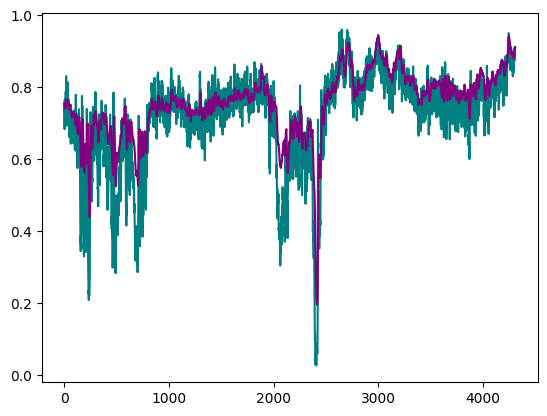

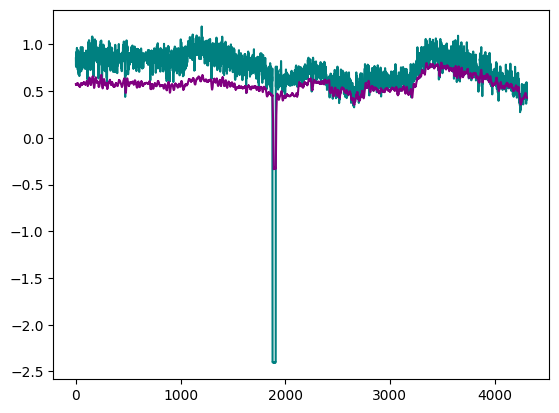

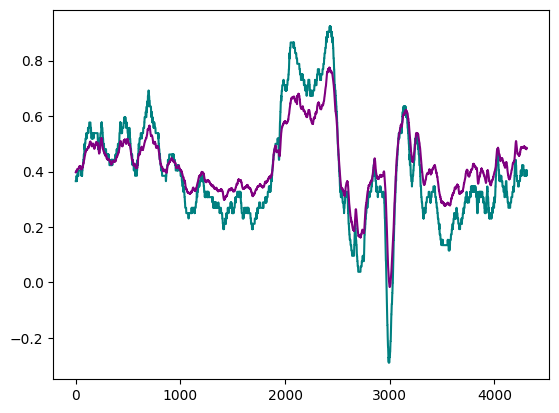

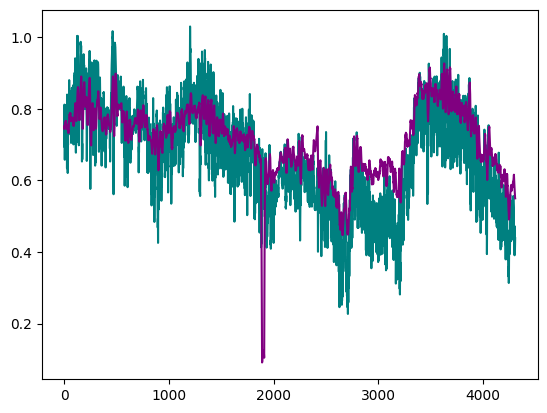

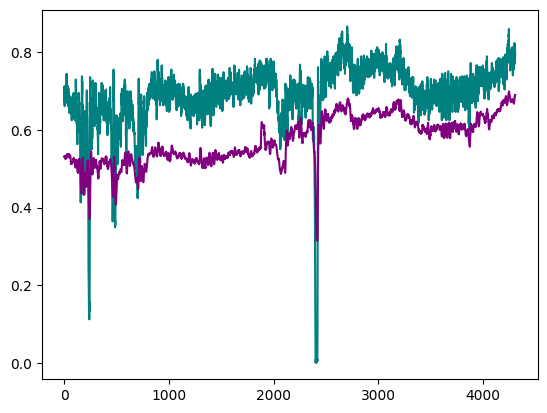

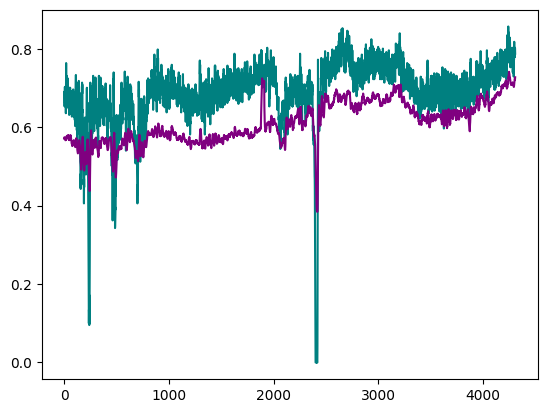

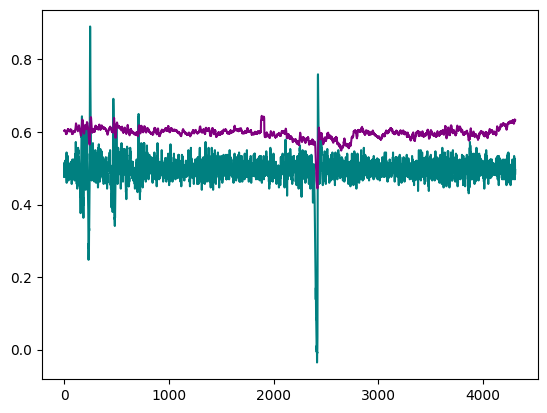

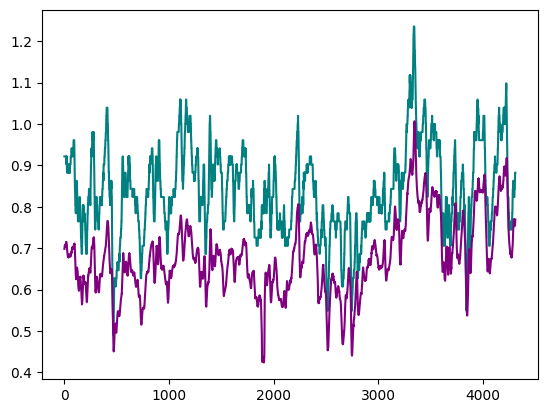

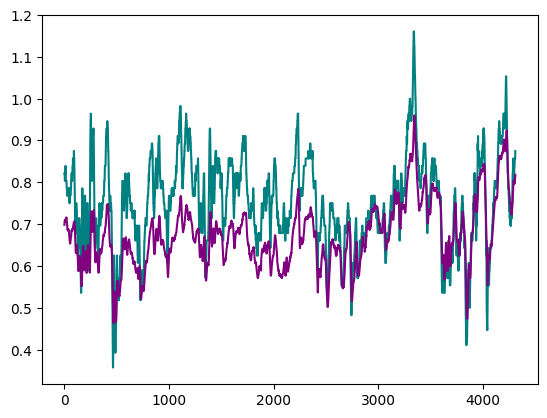

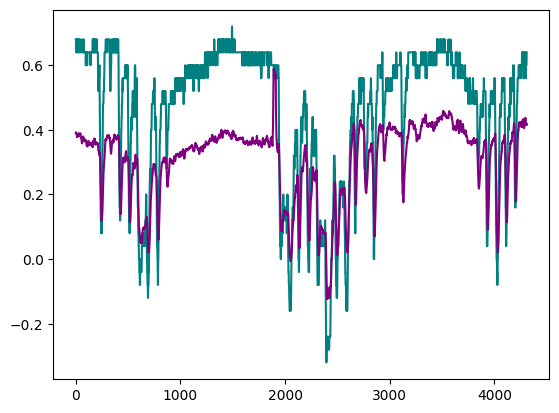

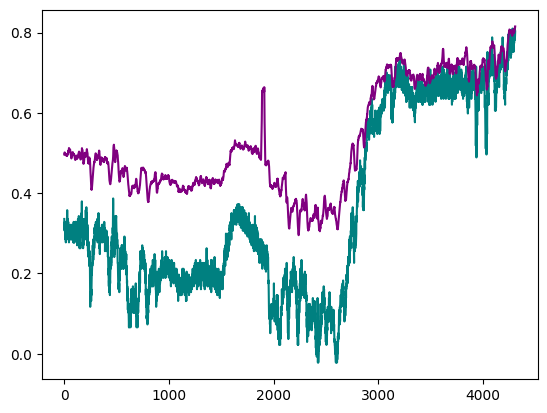

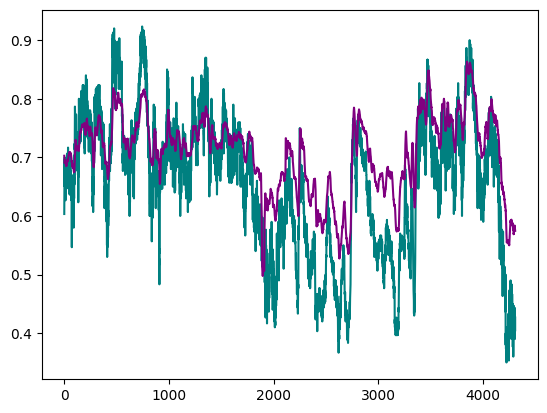

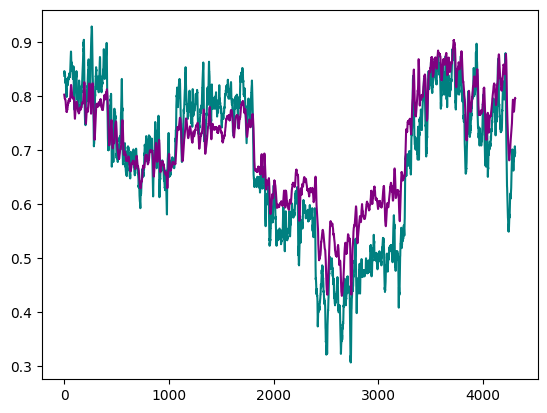

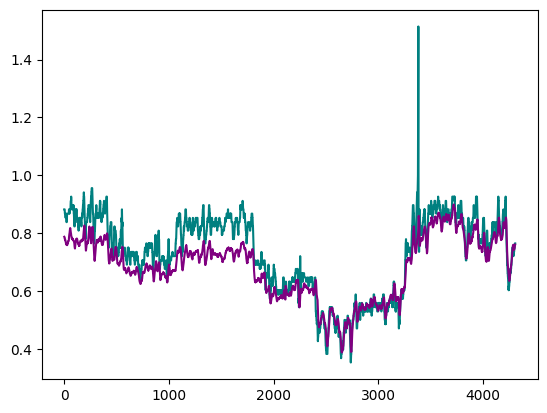

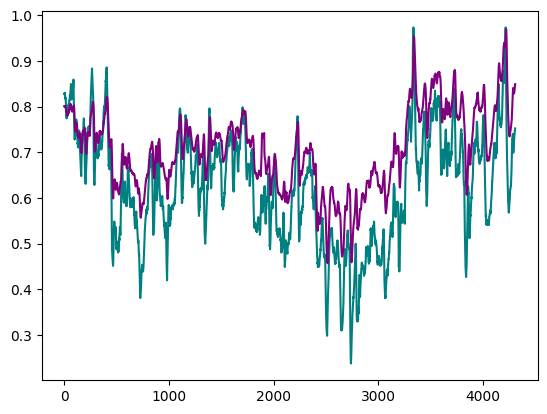

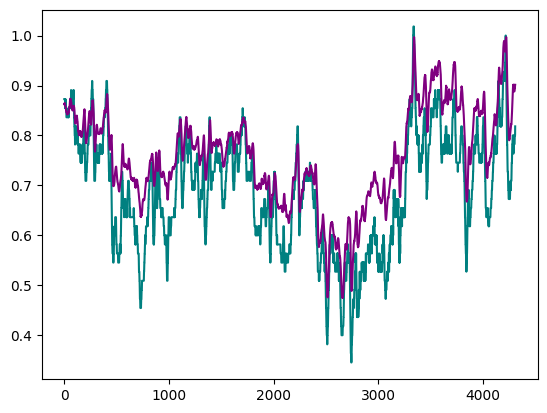

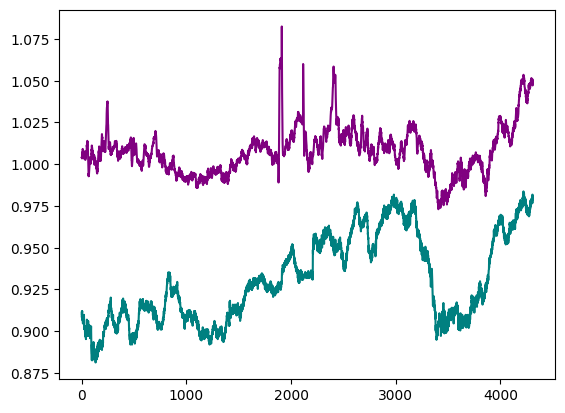

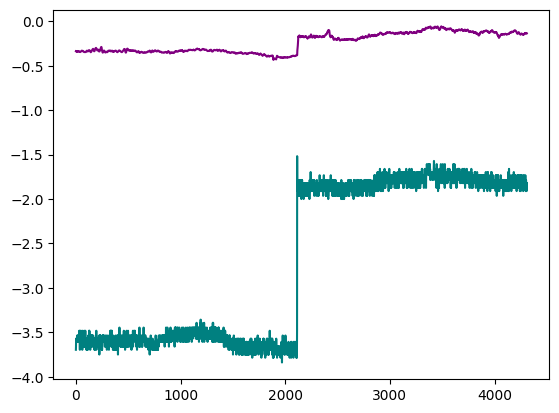

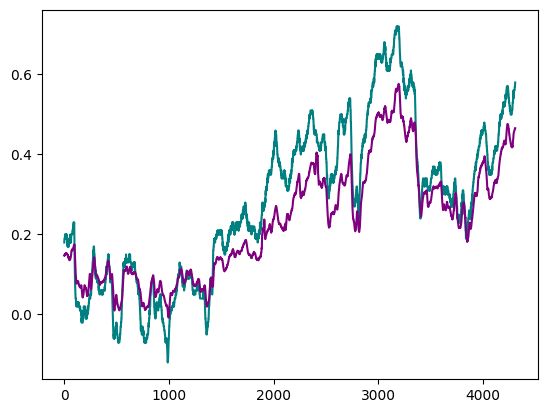

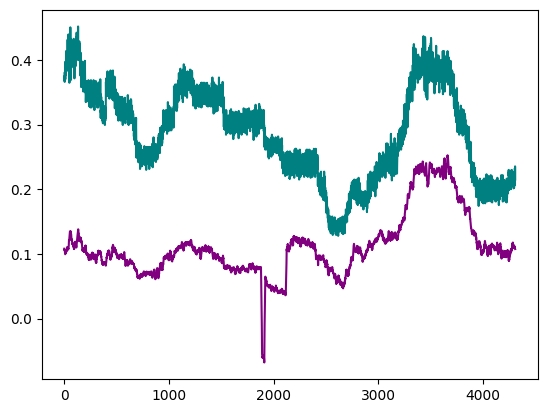

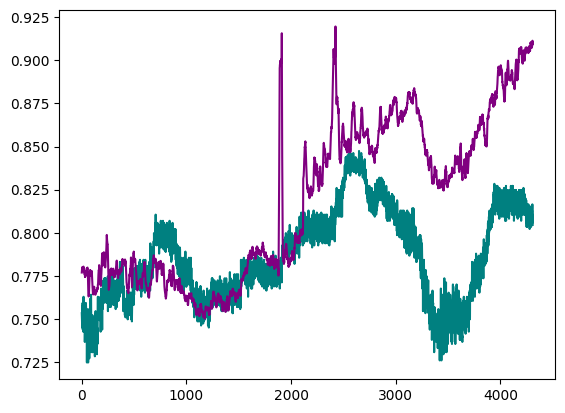

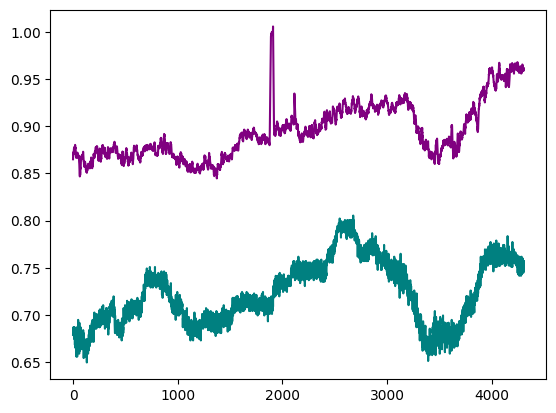

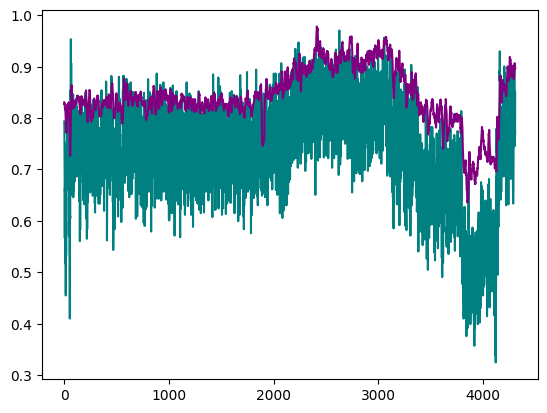

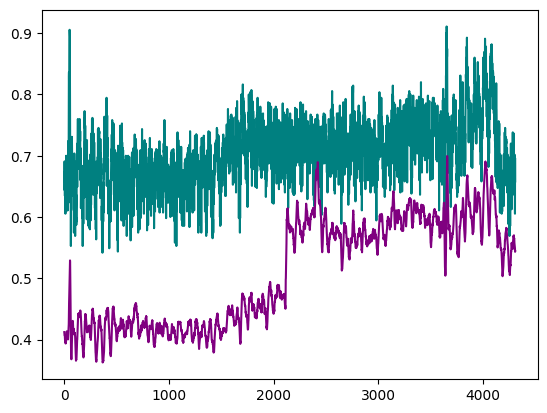

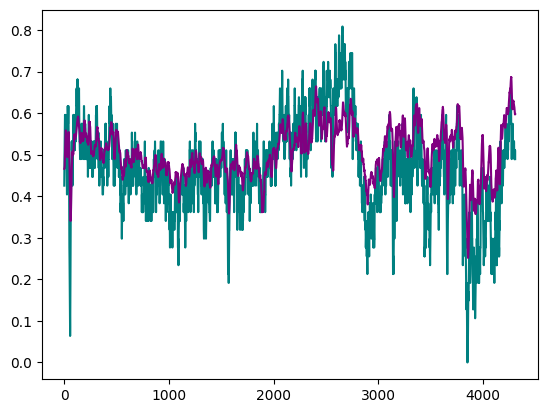

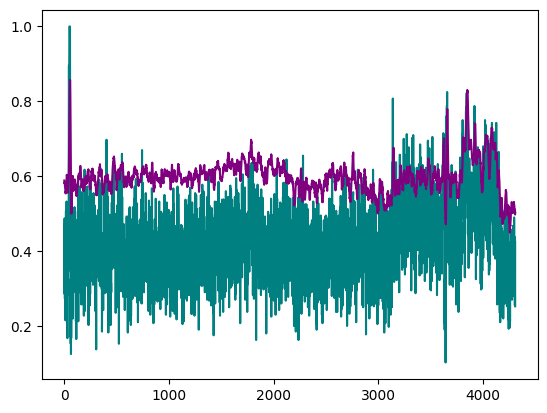

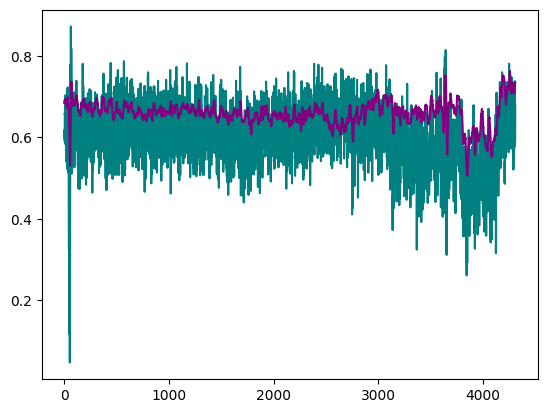

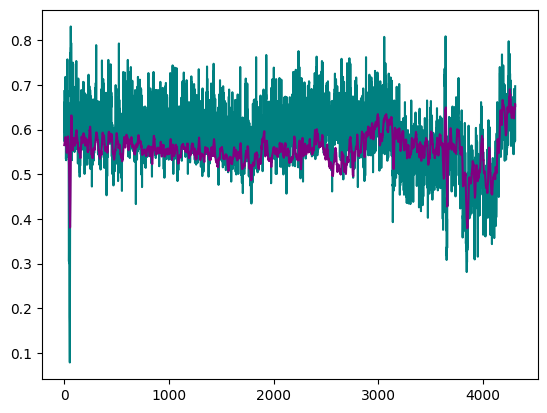

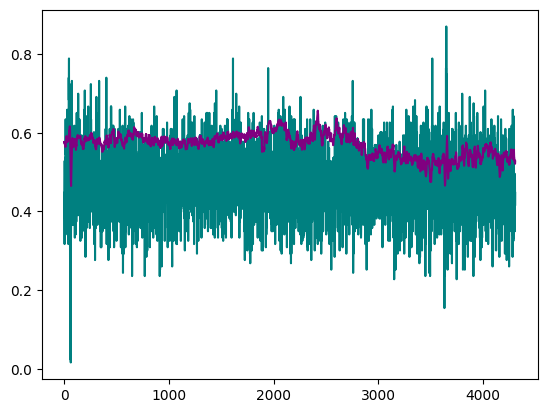

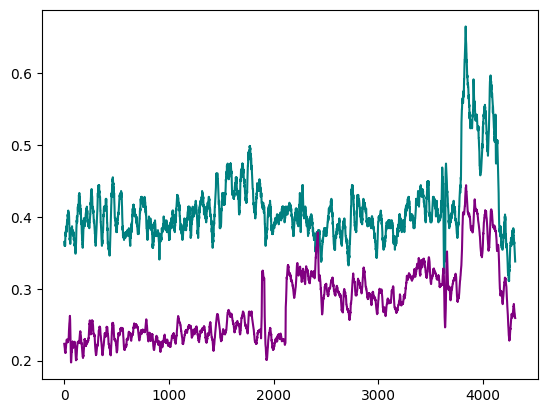

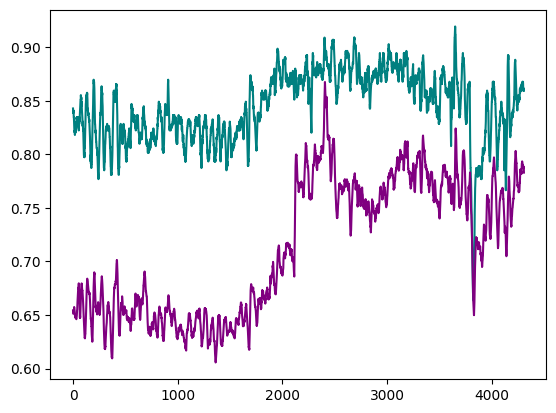

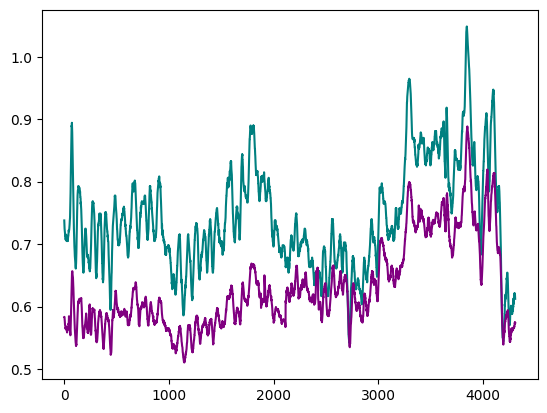

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Encoder + Decocder (current attempt)
for sensor in range(num_sensors):
    pred = np.array(pred)
    truth = np.array(truth)
    plt.plot(truth[:,sensor], color="teal")
    plt.plot(pred[:,sensor], color="purple")
    plt.show()